# Binary Task Notebook

### Contains Code for Binary task and models created

In [10]:
# Import required libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

#tqdm is for progress bar functionality in code, must be installed for code to function (TO DO: include exception if tqdm not imported )
from tqdm import tqdm


from sklearn.metrics import roc_curve, roc_auc_score

import pickle as pkl
import cv2

# 1. Loading Dataset and doing final preprocessing
### We Load the preprocessed data and carry out PCA on the image array here for the binary training and test data
### 1.1 Loading Datasets

In [2]:
#We can do PCA for the images but must be done separately for binary and multiclass task as the data must be split first
#This is because we must do PCA on the training data only (fit and transform it) and then only use the transform on the test data to prevent bias
#We select 400 components as it provides around 96% explained variance (can get the exact value)

#Reading created pkl files for binary labels and image data.
Binary_labels = pd.read_pickle('./dataset/Y_Binary_label.pkl')
Flattened_MRI_Array = pd.read_pickle('.\dataset\Image_DF_Flat.pkl')

#For Display
print(Binary_labels)
Flattened_MRI_Array


      MRI_Binary_Label
0                  1.0
1                  0.0
2                  1.0
3                  1.0
4                  1.0
...                ...
2995               0.0
2996               1.0
2997               1.0
2998               1.0
2999               1.0

[3000 rows x 1 columns]


,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,1,1,2,2,3,3,3,3,3,2,...,40,67,63,29,44,62,3,3,3,3
1,3,2,2,2,2,2,2,2,2,2,...,1,1,0,1,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,48,44,46,33,43,38,47,34,1,0
3,0,0,0,0,1,1,1,2,1,2,...,2,2,2,2,3,4,24,26,5,2
4,1,1,1,1,1,0,0,6,1,20,...,157,112,183,133,43,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,5,1,1,3,1,0,5,6,6,3,...,1,1,1,2,3,4,1,2,0,3
2996,1,1,2,2,2,2,3,2,3,3,...,72,70,42,9,4,4,2,4,2,2
2997,0,3,2,2,2,2,2,2,2,2,...,27,21,27,14,4,3,2,1,3,0
2998,2,2,2,2,3,3,3,3,4,3,...,153,63,86,81,59,71,26,7,5,3


In [15]:
#Taking just the label portion for editing into our Target Y array
Y = Binary_labels[['MRI_Binary_Label']]
print(Y.shape)

X = Flattened_MRI_Array
print(X.shape)

(3000, 1)
(3000, 784)
ERROR! Session/line number was not unique in database. History logging moved to new session 173


### 1.2 Splitting data in to training and testing sets

In [16]:
# Split the data into training and testing(70% training and 30% testing data)
xTrain,xTest,yTrain,yTest=train_test_split(X, Y, train_size = 0.7)

#Rescaling the dataframe as the pixel values range from 0 to 255
#We want it to be between 0 to 1 to let it pass through the NN and models
xTrain_Scaled = xTrain/255
xTest_Scaled = xTest/255

### 1.3 PCA

In [17]:
#Initialising PCA with 400 components determined in preprocessing notebook
Binary_PCA = PCA(n_components = 400)

#Fitting and Transforming training dataset
xTrain_PCA = Binary_PCA.fit_transform(xTrain_Scaled)

#We only transform test dataset as we do not want the model to learn about the test data statistics
xTest_transformed = Binary_PCA.transform(xTest_Scaled)

#Prints the percentage of explained variance to verify it is greater than our threshold of 95%
print(np.cumsum(Binary_PCA.explained_variance_ratio_ * 100)[-1])

96.49854310968563


# 2. Model Building

In [18]:
#Importing libraries used for SVM classification
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV


## 2.1 SVM Model

In [14]:
#Training model using SVC without hyperparameter tuning
binary_SVM_base = SVC()
binary_SVM_base.fit(xTrain_PCA, yTrain.values.ravel())

#Printing prediction results
binary_SVM_base_pred = binary_SVM_base.predict(xTest_transformed)
print("The Result for SVM without hyperparameter tuning is:")
print(classification_report(yTest, binary_SVM_base_pred))

#Printing the confusion matrix for SVM without tuning
print("The confusion matrix is:")
print(confusion_matrix(yTest, binary_SVM_base_pred))

The Result for SVM without hyperparameter tuning is:
              precision    recall  f1-score   support

         0.0       0.92      0.57      0.70       121
         1.0       0.94      0.99      0.96       779

    accuracy                           0.94       900
   macro avg       0.93      0.78      0.83       900
weighted avg       0.93      0.94      0.93       900

The confusion matrix is:
[[ 69  52]
 [  6 773]]


In [18]:
#Using SVM but this time with gridsearch to tune hyperparameter

#Define the parameter ranges
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf','sigmoid','linear']
}

Binary_SVM_grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1, cv = 10)

#Fitting model with grid search
Binary_SVM_grid.fit(xTrain_PCA, yTrain.values.ravel())

Fitting 10 folds for each of 75 candidates, totalling 750 fits


GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'sigmoid', 'linear']},
             verbose=1)

In [19]:
#Display the best parameters after the hyperparameter tuning
print("The best hyperparameters found by gridsearch are:")
print(Binary_SVM_grid.best_params_)

#Print the new details of the SVM model after tuning
print("The new model created after hyperparameter tuning is:")
print(Binary_SVM_grid.best_estimator_)

The best hyperparameters found by gridsearch are:
{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
The new model created after hyperparameter tuning is:
SVC(C=100, gamma=0.01)


In [20]:
#Now running the tuned model with the test data to obtain the classification report
Tuned_SVM_pred = Binary_SVM_grid.predict(xTest_transformed)

#Print classification report
print("The Result for SVM with hyperparameter tuning via gridsearch is:")
print(classification_report(yTest, Tuned_SVM_pred))

#Printing the confusion matrix for SVM without tuning
print("The confusion matrix is:")
print(confusion_matrix(yTest, Tuned_SVM_pred))

The Result for SVM with hyperparameter tuning via gridsearch is:
              precision    recall  f1-score   support

         0.0       0.86      0.79      0.82       121
         1.0       0.97      0.98      0.97       779

    accuracy                           0.95       900
   macro avg       0.91      0.89      0.90       900
weighted avg       0.95      0.95      0.95       900

The confusion matrix is:
[[ 96  25]
 [ 16 763]]


In [42]:
FPR_Tuned_SVM, TPR_Tuned_SVM_SVM, Tuned_SVM_SVM_thres = roc_curve(yTest, Tuned_SVM_pred)

FPR_Base_SVM, TPR_Base_SVM, Base_SVM_thres = roc_curve(yTest, binary_SVM_base_pred)


In [45]:
print('roc_auc_score for Tuned SVM: ', roc_auc_score(yTest, Tuned_SVM_pred))
print('roc_auc_score for Base SVM: ', roc_auc_score(yTest, binary_SVM_base_pred))

roc_auc_score for Tuned SVM:  0.8864246384960588
roc_auc_score for Base SVM:  0.7812728757996584


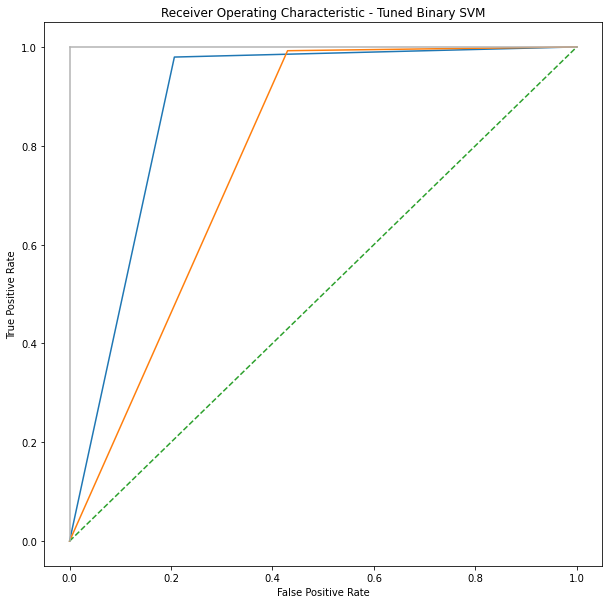

In [46]:
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Tuned Binary SVM')

#This plot is our tuned SVM model
plt.plot(FPR_Tuned_SVM, TPR_Tuned_SVM_SVM)

#This plot is the base SVM model
plt.plot(FPR_Base_SVM, TPR_Base_SVM)

#Optimal Model line
plt.plot([0, 1], ls="--")

plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [49]:
#Saving tuned and base SVM models
save_path = "./Models"
Tuned_SVM_filename = 'Tuned_SVM_model.sav'
Base_SVM_filename = 'Base_SVM_model.sav'


ERROR! Session/line number was not unique in database. History logging moved to new session 166


In [50]:
#Using Pickle to put them in files
pkl.dump(binary_SVM_base , open(os.path.join(save_path, Base_SVM_filename), 'wb'))
pkl.dump(Binary_SVM_grid, open(os.path.join(save_path, Tuned_SVM_filename), 'wb'))

In [53]:
#Code to test loading of trained tuned SVM model
load_tuned_SVM = pkl.load(open('.\Models\Tuned_SVM_model.sav', 'rb'))
#Gets the best parameter values from loaded model
best_param = load_tuned_SVM.best_params_
#Prints out the parameter values
#Output should match earlier .best_params_ output
print(best_param)

{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}


## 2.2 Convolutional Neural Network